## <span style="color:green">**Version en cours**</span>

# Segmentez des clients d'un site e-commerce
## Notebook 3 : Tests de modèles de clustering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* Feature ingineering (cf Notebook 2)
* **Tests de modèles de clustering** : c'est l'objet de ce notebook  
* Simulation d'un contrat de maintenace (Notebook 4)  

**Tests de modèles de clustering**  
* Objectif :
   * bla bla bla 

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

**Premier test de clustering via scikit-learn KMeans**  
* Premier test avec 5 clusters
* Détermination du nombre optimal de clusters
* Test avec 7 clusters

**Second test KMeans - Feature `Montant` passée au log**  
* KMeans - 7 clusters  
* KMeans - 3, 4, ou 5 clusters  

**Troisième test KMeans - Feature `Montant` normalisée via QuantileTransformer**  
* Détermination du nombre optimal de clusters
* Entraînement du modèle - 4 clusters
* Entraînement du modèle - 5 clusters

**Quatrième test KMeans - Feature `Montant` classée par tranches**  
* Détermination du nombre optimal de clusters
* KMeans 6 clusters

**Test DBSCAN**  
* Feature `Montant` normalisée par quantiles  
* Feature `Montant` classée par tranches  
* Résultats DBSCAN  

**Test AgglomerativeClustering**  
* Choix des hyperparamètres
* Feature `Montant` normalisée par quantiles  
* Feature `Montant` classée par tranches  
* Conclusion AgglomerativeClustering    

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('yellowbrick')
install_package('scipy')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.
yellowbrick est déjà installé.
scipy est déjà installé.


* Import des modules

In [4]:
# Import des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import scipy.cluster.hierarchy as sch

* Paramétrages

In [5]:
# Taille par défaut des graphiques
mpl.rcParams["figure.figsize"] = (9,6)

## 1.3 Fonctions

In [6]:
def fit_kmeans(X, k, random_state=0):
    """Instancie un modèle KMeans et renvoit les labels
    Arguments :
    X (DataFrame)      : données
    k (int)            : nombre de clusters
    random_state (int) : seed
    Retour :
    (numpy.ndarray) : labels des clusters
    """
    # Initialisation du modèle
    kmeans = KMeans(n_clusters=k, random_state=0)
    # Entraînement du modèle
    kmeans.fit(X)

    return kmeans.labels_

In [7]:
def fit_dbscan(X, epsilon, min_samples):
    """Applique l'algorithme DBSCAN sur le dataset fourni
    Arguments :
    X (dataframe) : dataframe contenant les features
    eps (float)   : hyperparamètre 'eps' de DBSCAN (distance maximale entre 2 points d'un même cluster)
    min_samples   : hyperparamètre 'min_samples' de DBSCAN (nombre de points minimum pour constituer un cluster)
    Retour :
    n_clusters_ (int) : nombre estimé de clusters
    n_noise_ (int)    : nombre estimé de points de bruits
    labels (ndarray)  : tableau des labels des clusters
    """
    # Fit du modèle DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
    # Récupération des étiquettes des clusters
    labels = dbscan.labels_
    # Nombre de labels uniques (= nombre de clusters), en ignorant les éventuels points de bruit
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # Nombre de points de bruits
    n_noise_ = list(labels).count(-1)

    return n_clusters_, n_noise_, labels

In [8]:
def display_customer_distribution_by_cluster(dataframe, customer_feature, cluster_feature):
    """Affiche un tableau avec le label du cluster, le nombre de clients et le pourcentage de clients
    et le piechart associé
    Arguments :
    dataframe (DataFrame)  : dataframe dans lequel se trouvent les données
    customer_feature (str) : nom de la variable contenent les valeurs uniques représentant les clients
    cluster_feature (str)  : nom de la variable contenant les labels de clusters
    """
    # Nombre de clients par clusters
    df_number_of_customers_by_clusters = dataframe.groupby(cluster_feature)[customer_feature].count().reset_index()
    # Ajout pourcentages
    number_of_customers = dataframe.shape[0]
    df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters[customer_feature] / number_of_customers) * 100, 2)

    display(df_number_of_customers_by_clusters.rename(columns={customer_feature: 'Nombre de clients'}))
    print()
    
    # Graphique de répartition
    colors = sns.color_palette('pastel')[0:10]
    plt.title('Répartition des clients par clusters')
    plt.pie(df_number_of_customers_by_clusters[customer_feature], labels=df_number_of_customers_by_clusters[cluster_feature], colors = colors, autopct='%.2f%%')
    plt.show()

In [9]:
def plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=None):
    """Affiche le graphique KElbowVisualizer d'un modèle KMeans permettant la recherche du nombre optimal de clusters
    Elbow Method (metric='distorion') ou Calinski-Harabasz (metric='Calinski-Harabasz')
    Arguments :
        random_state (int) : seed
        k (tuple)          : (min, max+1)
        metric (str)       : 'distortion' par défaut (somme des distances au carré de chaque point à son centre de cluster)
        X (DataFrame)      : dataset d'input
    """
    
    # Instanciation du modèle et du visualiseur
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(
        kmeans,
        k=k,
        metric=metric
    )
    
    # Alimentation du visualiseur
    visualizer.fit(X)
    
    # Visualisation
    visualizer.finalize()

    return

In [10]:
def display_silhouette_scores(X, random_state=0, k_values=range(3, 11)):
    """Affiche les scores de silhouette d'un modèle KMeans pour la recherche du nombre optimal de clusters
    Renvoit le nombre de clusters ayant obtenu le meilleur score
    Arguments :
        X (DataFrame)      : dataset d'input
        random_state (int) : seed
        k (range)          : plage de k à tester
    Retour :
        silhouette_k (int) : nombre de clusters du meilleur score
    """
    silhouette_scores = []
    silhouette_best_score, silhouette_k = -1, -1
    
    # Calcul des scores de silhouette pour chaque valeur de k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X)
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        if silhouette_avg > silhouette_best_score:
            silhouette_best_score = silhouette_avg
            silhouette_k = k
            
    # Affichage du tableau des scores
    df_silhouette_scores = pd.DataFrame({'k': k_values, 'Score de Silhouette': silhouette_scores}).set_index('k')
    display(df_silhouette_scores.sort_values('Score de Silhouette', ascending=False))
    
    return silhouette_k

In [11]:
def plot_silhouettevisualizer(X, k):
    """Affiche le graphique SilhouetteVisualizer d'un modèle KMeans
    Arguments :
    X (DataFrame) : données
    k (int)       : nombre de clusters
    """
    # Instanciation du modèle KMeans
    model = KMeans(k)
    # Instanciation du visualiseur
    visualizer = SilhouetteVisualizer(model)
    # Alimentation du visualiseur
    visualizer.fit(X)
    # Visualisation du graphique
    visualizer.finalize() 

In [12]:
def plot_elbow_nearest_neighbors(X, k=5):
    """Affiche la courbe distances / indices qui permet de visualiser la valeur d'epsilon du modèle DBSCAN
    en fonction du nombre d'observations du dataframe fourni.
    Arguments:
    X (DataFrame) : features pour DBSCAN
    k (int)       : nombre de points voisins à prendre en considération pour le calcul de la distance
    Retour:
    distance_max  : distance maximum entre un point et ses k plus proches voisins (= epsilon max)
    """
    # Instanciation
    nearest_neighbors = NearestNeighbors(n_neighbors=5)
    # Alimentation du modèle
    neighbors = nearest_neighbors.fit(X)
    # Récupération des distances et indices des points observés
    distances, indices = neighbors.kneighbors(X)
    # Tri par distance pour le graphique
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    # Distance maximale
    max_distance = max(distances)
    
    # Affichage de la courbe distances / indices
    plt.figure(figsize=(6, 4))
    plt.plot(distances)   
    plt.title("Méthode du coude pour optimiser le choix d'epsilon")
    plt.xlabel("Echantillon (10 % des observations)")
    plt.ylabel("Distance au plus proches voisins")
    plt.show()
    
    return max_distance

## 1.4 Chargement des données

In [13]:
# Chargement 'df_features'
df_features = pd.read_csv('df_features.csv')

In [14]:
# Affichage des premières et dernières lignes
df_features

,Client,Récence,Fréquence,Montant,Récence_minmax,Fréquence_minmax,Montant_minmax,Montant_log,Montant_qt,Montant_class,Montant_log_minmax,Montant_class_minmax,Satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,4.962145,0.636131,3,0.363304,0.375,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,3.338967,0.021178,1,0.136688,0.125,4.0
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4.468434,0.398488,2,0.294376,0.250,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3.798182,0.118413,1,0.200801,0.125,4.0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,5.287711,0.777711,4,0.408757,0.500,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,7.634540,0.993256,8,0.736404,1.000,5.0
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,4.449452,0.388941,2,0.291726,0.250,4.0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4.731450,0.518331,3,0.331096,0.375,5.0
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,4.902976,0.605161,3,0.355043,0.375,5.0


# 2 Premier test de clustering via scikit-learn KMeans

## 2.0 Premier test avec 5 clusters

Ce test est juste une découverte du modèle, avec le choix de 5 clusters

In [15]:
# Nombre de clusters
k = 5

In [16]:
# Sélection des features
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_minmax']]

In [17]:
# Entrainement du modèle
labels = fit_kmeans(X, k, random_state=0)

In [18]:
# Ajout des labels de cluster à 'df_features'
df_features['Cluster KMeans'] = labels

In [19]:
# Affichage du résultat
display(df_features)

,Client,Récence,Fréquence,Montant,Récence_minmax,Fréquence_minmax,Montant_minmax,Montant_log,Montant_qt,Montant_class,Montant_log_minmax,Montant_class_minmax,Satisfaction,Cluster KMeans
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,4.962145,0.636131,3,0.363304,0.375,5.0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,3.338967,0.021178,1,0.136688,0.125,4.0,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4.468434,0.398488,2,0.294376,0.250,3.0,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3.798182,0.118413,1,0.200801,0.125,4.0,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,5.287711,0.777711,4,0.408757,0.500,5.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,7.634540,0.993256,8,0.736404,1.000,5.0,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,4.449452,0.388941,2,0.291726,0.250,4.0,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4.731450,0.518331,3,0.331096,0.375,5.0,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,4.902976,0.605161,3,0.355043,0.375,5.0,2


,Cluster KMeans,Nombre de clients,%
0,0,30627,32.20
1,1,2900,3.05
2,2,29719,31.24
3,3,18451,19.40
4,4,13424,14.11


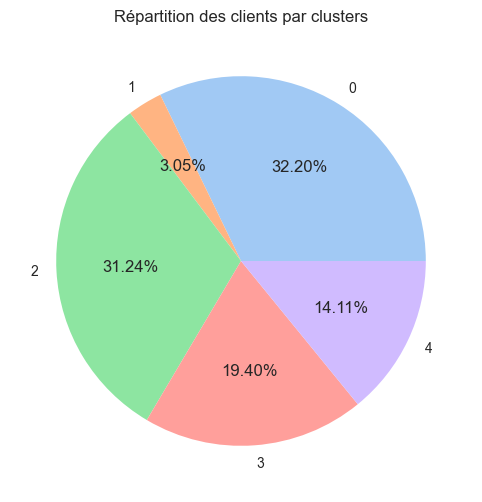

In [20]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster KMeans')

* Le modèle segmente bien les clients en **5 clusters** 
* Chaque segment représente **entre 3 et 32 % des clients**

## 2.1 Détermination du nombre optimal de clusters

### 2.1.1 Méthode du Coude (Elbow Method)

* Cette méthode consiste à tracer le pourcentage de variance expliquée en fonction du nombre de clusters.  
* Le point où l'ajout de clusters supplémentaires ne donne pas de meilleure explication des données permet de déterminer le nombre optimal de clusters. Ce point ressemble souvent à un "coude" sur le graphique.  
* La bibliothèque `yellowbrick` propose des outils de visualisation pour la méthode du coude

* Graphique KElbowVisualizer pour un nombre de clusters **k** compris entre 3 et 10

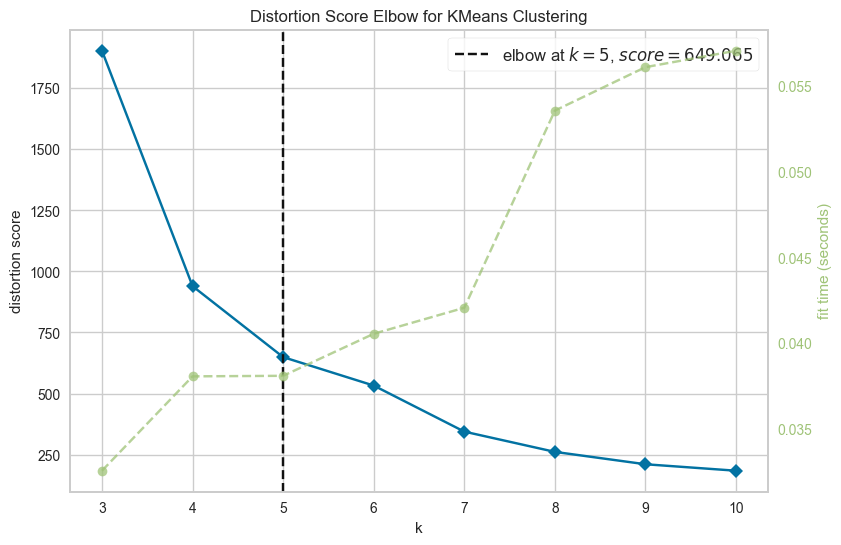

In [21]:
# Graphique KElbowVisualizer Elbow Method, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

* **Avant k=5** : chaque augmentation de k entraîne une amélioration significative de la performance du clustering (mesurée par une forte diminution de la distorsion), la pente de la courbe bleue est importante  
* **Après k=5** : la courbe commence à s'aplatir, les bénéfices de l'ajout de clusters supplémentaires diminuent, l'ajout de clusters supplémentaires n'apporte pas d'amélioration proportionnelle de la performance
* **k=5** : c'est le nombre de clusters optimal selon cette méthode
* Le score de **649.065** représente la valeur de distorsion (somme des distances au carré de chaque point à son centre de cluster) pour **k=5**

* Le coude n'est pas franchement marqué, d'autres méthodes pourront confirmer ou infirmer le choix de 5 clusters
* Remarque : la pente de la courbe redevient un peu plus forte entre 6 et 7 clusters, choisir 7 clusters serait-il pertinent ?

### 2.1.2 Methode du Score de Silhouette

* Le score de silhouette calcule la distance entre les clusters ainsi que la cohésion au sein des clusters :  
   * Soit $a$ la distance moyenne d'un point avec les autres points du même cluster  
   * Soit $b$ la distance moyenne d'un point aves les clusters les plus proches  
   * La différence $a-b$, si elle est positive, indique que le point est bien positionné dans son cluster  
   * Si elle est négative, le point est situé dans un cluster voisin  
   * Plus cette différence est proche de 0, plus le point se situe à la limite de 2 clusters
   * Le ratio $\frac{a-b}{max(a, b)}$ est le coefficient de silhouette du point
   * La moyenne de tous les coefficients de silhouettes est le score de sihhouette, indiquant la qualité de la segmentation
* Un score plus élevé indique une meilleure définition des clusters
* La bibliothèque `yellowbrick` propose des outils de visualisation pour cette méthode

#### 2.1.2.1 Calcul des scores de silhouette

* Comme pour la méthode du coude, recherche du meilleur score de silhouette pour **k** compris entre 3 et 10

In [22]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.597566
4,0.575646
7,0.547662
5,0.543333
8,0.542496
6,0.539311
9,0.537341
10,0.522042


* Le meilleur score de silhouette (**0.598**) est obtenu lorsque KMeans segmente les clients en **3** clusters
* Cette segmentation semble peu pertinente du point de vue métier, Olist attend un plus grand nombre de groupes de clients

#### 2.1.2.2 Visualisation

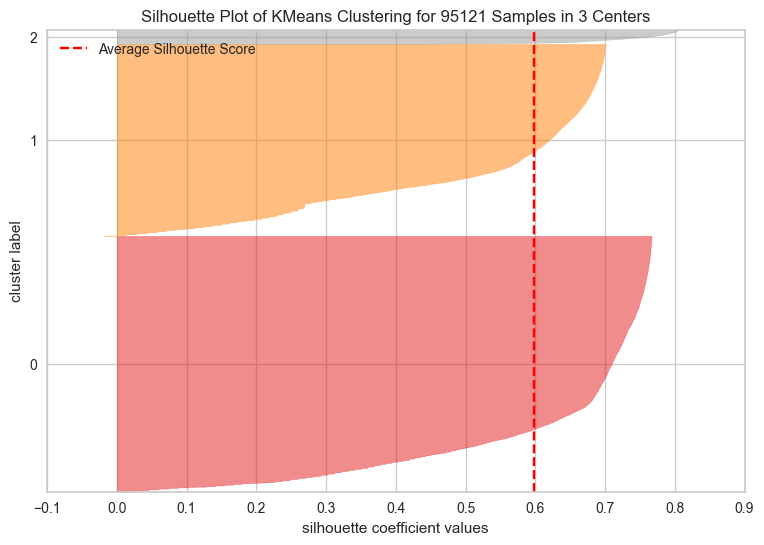

In [23]:
# Affichage SilhouetteVisualizer
plot_silhouettevisualizer(X, silhouette_k)

* Le nombre de clients n'est pas uniformément réparti, le cluster 2 (gris) contient beucoup moins de points
* La moyenne des coefficients de silhouette est très proche de **0.6**, la qualité de clustering semble relativement bonne  
* Aucun coefficient n'est négatif, signe qu'aucun client n'a été mal positionné  

### 2.1.3 Méthode Calinski-Harabasz (score du rapport variance)

* Mesure à quel point les points sont proches les uns des autres au sein de chaque cluster
* Évalue à quel point les clusters sont éloignés les uns des autres
* Un score élevé indique un clustering mieux défini  

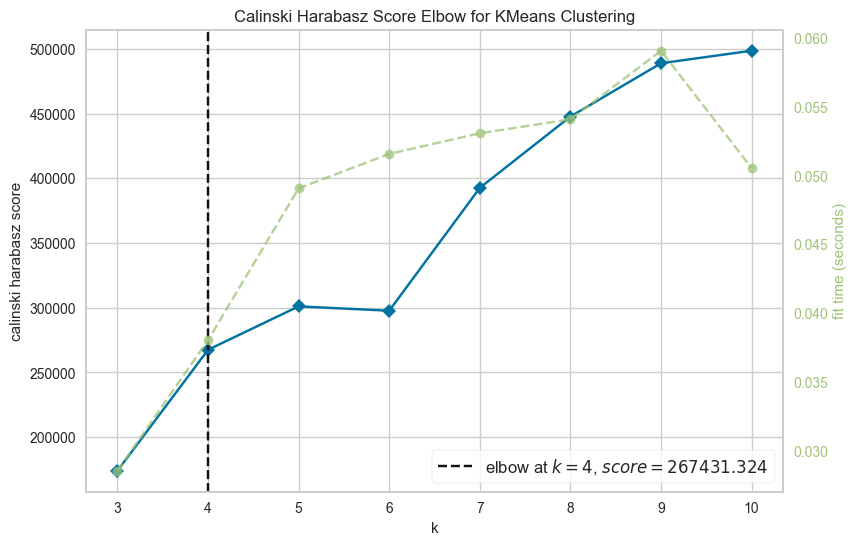

In [24]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* Avec une pente qui augmente moins fortement entre 4 et 5 clusters, la méthode Calinski Harabasz préconise une **segmentation en 4 clusters** 
* Une segmentation en 7 clusters semble aussi intéressante puisque la pente de la courbe augmente de manière significative entre 6 et 7

### 2.1.4 Nombre de clusters retenus

* Les différentes méthodes testées donnent des résultats différents :
| Méthode              | Nombre de clusters (k) | 
|----------------------|------------------------|  
| Elbow Method         | **5**                  |  
| Score de Silhouette  | **3**                  |  
| Calinski Harabasz    | **4**                  |
* Aucune des méthodes testées n'indique le même nombre idéal de clusters
* Les courbes des graphiques Elbow Method et Calinski Harabasz laissent présumer qu'une segmentation en **7** clusters pourrait étre intéressante

* Visualisation de la méthode des scores de silhouette avec **k=7**

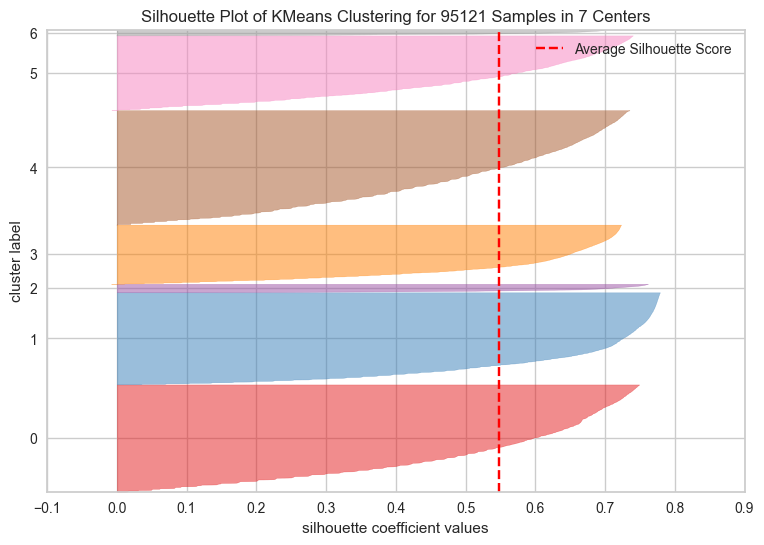

In [25]:
# Affichage SilhouetteVisualizer
plot_silhouettevisualizer(X, 7)

* La moyenne des coefficients de silhouette est d'environ **0.55**  
* Le cluster 2 est largement moins peuplé que les autres  
* Les coefficients sont positifs : il n'y a pas de chevauchement entre les clusters  

## 2.2 Test KMeans avec 7 clusters

### 2.2.1 Entrainement du modèle

In [26]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
df_features['Cluster KMeans'] = fit_kmeans(X, 7, random_state=0)

### 2.2.2 Affichage des résultats

In [27]:
# Affichage du résultat
display(df_features)

,Client,Récence,Fréquence,Montant,Récence_minmax,Fréquence_minmax,Montant_minmax,Montant_log,Montant_qt,Montant_class,Montant_log_minmax,Montant_class_minmax,Satisfaction,Cluster KMeans
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,4.962145,0.636131,3,0.363304,0.375,5.0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,3.338967,0.021178,1,0.136688,0.125,4.0,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4.468434,0.398488,2,0.294376,0.250,3.0,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3.798182,0.118413,1,0.200801,0.125,4.0,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,5.287711,0.777711,4,0.408757,0.500,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,7.634540,0.993256,8,0.736404,1.000,5.0,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,4.449452,0.388941,2,0.291726,0.250,4.0,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4.731450,0.518331,3,0.331096,0.375,5.0,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,4.902976,0.605161,3,0.355043,0.375,5.0,2


### 2.2.3 Analyse des clusters

#### 2.2.3.1 Répartition des clients par cluster

,Cluster KMeans,Nombre de clients,%
0,0,21979,23.11
1,1,1747,1.84
2,2,24005,25.24
3,3,14857,15.62
4,4,11919,12.53
5,5,1153,1.21
6,6,19461,20.46


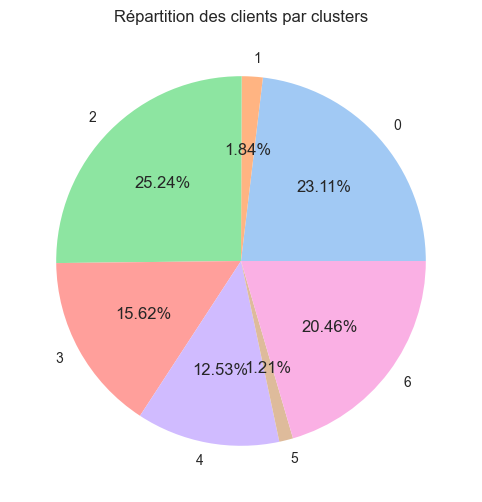

In [28]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster KMeans')

* La répartition est relativement homogène, à l'exception des clusters 1 et 5 beaucoup moins peuplés
* Sous réserve qu'il y ait un sens métier, cette segmentation peut être petinente

#### 2.2.3.2 Distributions des features par cluster

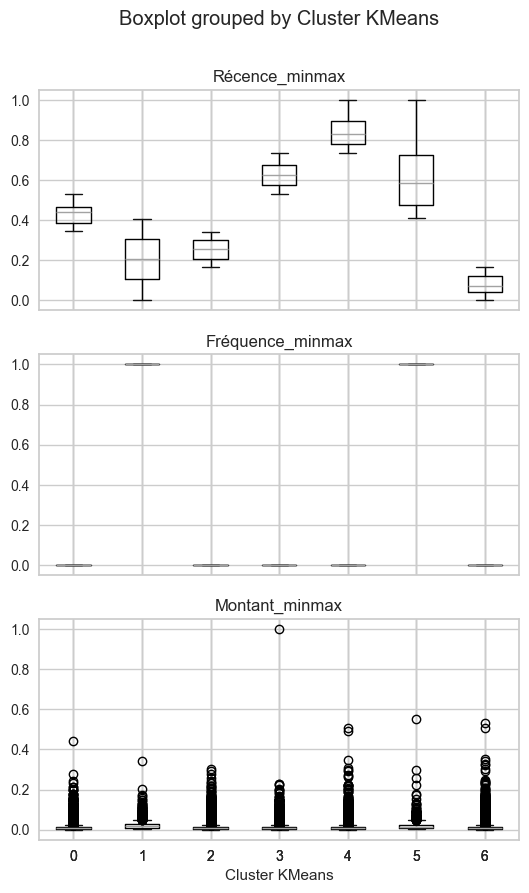

In [29]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_minmax'], by='Cluster KMeans', grid=True, figsize=(6, 10), layout=(3, 1))

* Les clusters 1 et 5 se distinguent facilement par une `Fréquence` à 1 (clients ayant passé plus d'une commande) avec une `Récence` plus faible pour le cluster 1 que pour le 5, sans chevauchement
* Si on fait abstraction des boxplots `Récence` des clusters 1 et 5, il n'y a pas chevauchement, le clustering se fait bien au niveau de cette feature
* La feature `Montant` n'est pas interprétable en l'état, les boxplots se chevauchent et montrent de nombreuses valeurs aberrantes. Il est particulièrement difficile d'analyser la segmentation par montants.

### 2.2.4 Conclusions du test

#### 2.2.4.1 Constat

* KMeans ne peut segmenter correctement le dataset compte-tenu de la feature `Montant`
* Les boxplots de cette variable pour chaque cluster montrent des distributions fortement asymétriques, avec de nombreux outliers
* Le boxplot de la variable d'origine montre une distribution similaire :

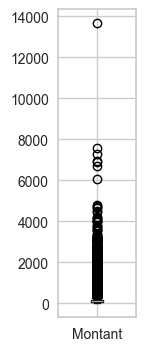

In [30]:
# Distribution `Montant_orig`
boxplot = df_features.boxplot(column='Montant', grid=True, figsize=(1, 4))

#### 2.2.4.2 Pistes

Il semble pertinent de transformer la variable `Montant` de manière à ce que sa distribution soit exploitable par le modèle.
* Utiliser une technique de mise à l'échelle robuste aux outliers (RobustScaler) ?
* Passer la variable au log ?
* Utiliser le coefficient de variation (Montant / moyenne des montants) ?
* Utiliser des plages de valeurs (clients ayant commandé pour - de 25 réals, ente 25 et 50,...)

* Ces pistes sont explorées dans le **"Notebook 2 - Feature ingineering"**, partie **"5 Feature ingineering variable `Montant`"**

# 3 Second test KMeans - Feature `Montant` passée au log

* Suite à la problématique de la forte asymétrie de la feature `Montant`, une version de cette variable a été passée au log, et un nouveau jeu de données a été généré

In [31]:
# Chargement du nouveau dataset
df_features = pd.read_csv('df_features.csv')

In [32]:
# Sélection des features
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_log_minmax']]

## 3.1 Détermination du nombre optimal de clusters

### 3.1.1 Elbow Method

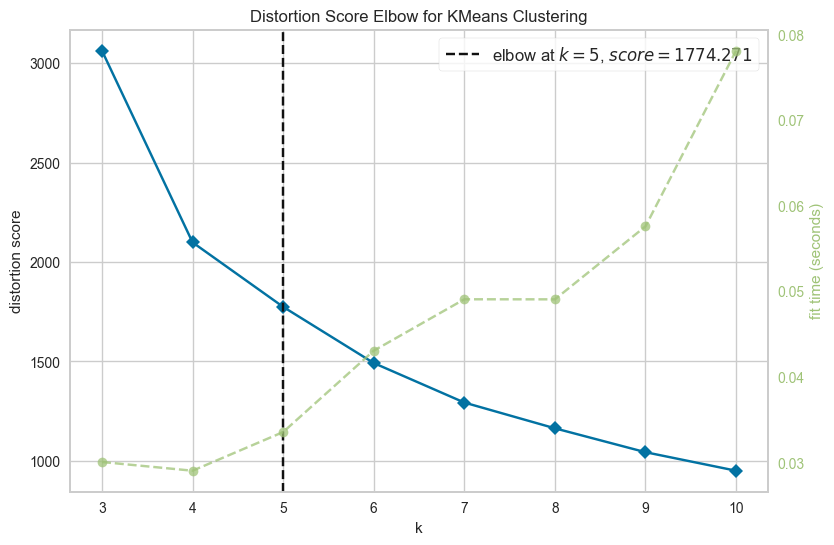

In [33]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

* Le résultat est identique a celui obtenu avant passage au log, la Méthode du Coude préconise uen segmentation en **5 clusters**
* En revanche on ne retrouve pas une pente plus forte en k = 6 et k = 7

### 3.1.2 Scores de Silhouette

In [34]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.492181
4,0.414738
5,0.379735
6,0.351411
7,0.346011
10,0.342225
9,0.340674
8,0.335504


* Le résultat est aussi strictement identique à celui obtenu avant transformation logarithmique : le meilleur score de silhouette (**0.598**) est obtenu lorsque KMeans segmente les clients en **3** clusters

* Le meilleur score de silhouette (**0.492**) est inférieur a celui obtenu précédemment, mais il correspond encore à une segmentation en **3** clusters

### 3.1.3 Calinski-Harabasz

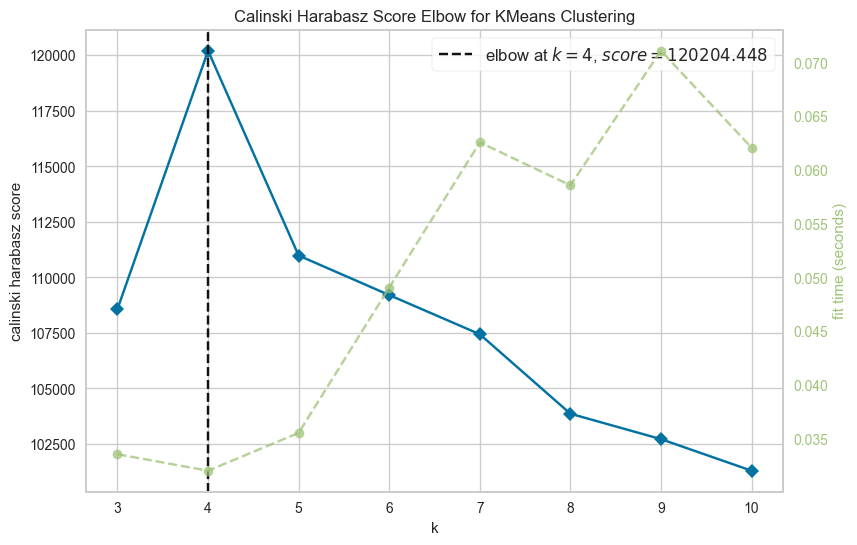

In [35]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* La méthode de Calinski Harabasz préconise une segmentation en **4 clusters**, de manière beaucoup plus nette qu'avant transformation logarithmique de la feature `Montant`

### 3.1.4 Nombre de clusters à tester

* Les différentes méthodes testées donnent des résultats différents :
| Méthode              | Nombre de clusters (k) | 
|----------------------|------------------------|  
| Elbow Method         | **5**                  |  
| Score de Silhouette  | **3**                  |  
| Calinski Harabasz    | **4**                  |
* Afin de comparer avec la version sans passage au log, un premier test sera effecué avec une segmentation en **7 clusters**
* Dans un second temps, les segmentations en **3, 4 ou 5 clusters** seront testées

## 3.2 KMeans - 7 clusters

### 3.2.1 Entrainement du modèle

In [36]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
df_features['Cluster KMeans'] = fit_kmeans(X, 7, random_state=0)

### 2.2.2 Affichage des résultats

In [37]:
# Affichage du résultat
display(df_features)

,Client,Récence,Fréquence,Montant,Récence_minmax,Fréquence_minmax,Montant_minmax,Montant_log,Montant_qt,Montant_class,Montant_log_minmax,Montant_class_minmax,Satisfaction,Cluster KMeans
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,4.962145,0.636131,3,0.363304,0.375,5.0,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,3.338967,0.021178,1,0.136688,0.125,4.0,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4.468434,0.398488,2,0.294376,0.250,3.0,5
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3.798182,0.118413,1,0.200801,0.125,4.0,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,5.287711,0.777711,4,0.408757,0.500,5.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,7.634540,0.993256,8,0.736404,1.000,5.0,6
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,4.449452,0.388941,2,0.291726,0.250,4.0,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4.731450,0.518331,3,0.331096,0.375,5.0,5
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,4.902976,0.605161,3,0.355043,0.375,5.0,4


### 3.2.3 Analyse des clusters

#### 3.2.3.1 Répartition des clients par cluster

,Cluster KMeans,Nombre de clients,%
0,0,20440,21.49
1,1,2900,3.05
2,2,18470,19.42
3,3,13540,14.23
4,4,14880,15.64
5,5,12169,12.79
6,6,12722,13.37


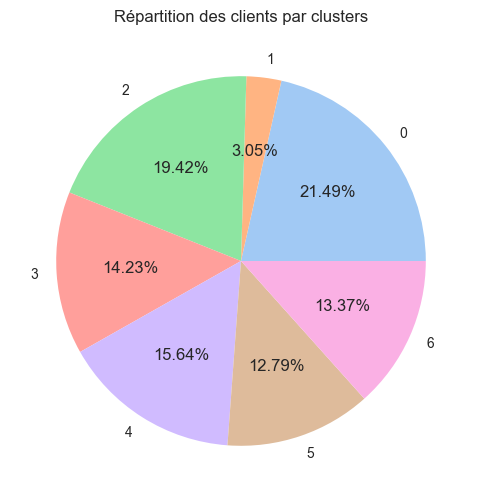

In [38]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster KMeans')

* La répartition semble légèrement plus homogène après transformation logarithmique de la variable `Montant`, avec maintenant 1 seul cluster moins peuplé  

#### 3.2.3.2 Distributions des features par cluster

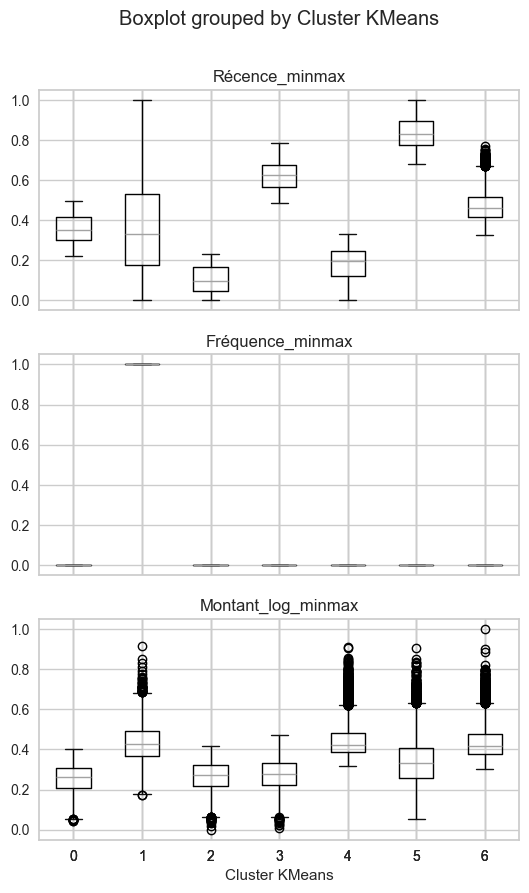

In [39]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_log_minmax'], by='Cluster KMeans', grid=True, figsize=(6, 10), layout=(3, 1))

* Hormis pour la feature `Fréquence`, les boxplots se chevauchent, indiquant des clients à cheval entre plusieurs cluster
* C'est particulièrement le cas au niveau de la feature `Montant`

* Le clustering est totalement différent : et au niveau de la répartition des clients, et au niveau des distributions des features
* La transformation logarithmique de la feature `Montant` n'est pas concluante.

## 3.3 KMeans avec 3, 4 ou 5 clusters

Les différentes méthodes de détermination du nombre de clusters optimal préconisent 3, 4 ou 5 clusters

* Tests de répartition des montants entre les clusters, pour 3, 4, ou 5 clusters

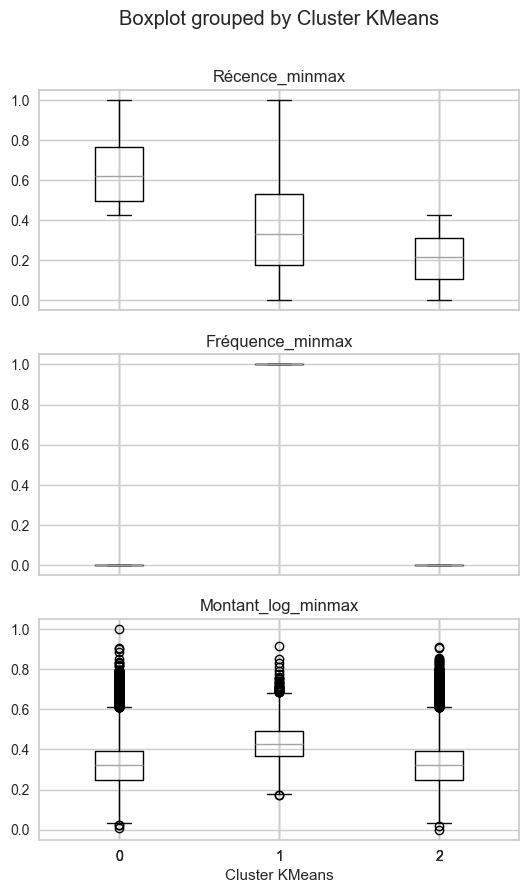

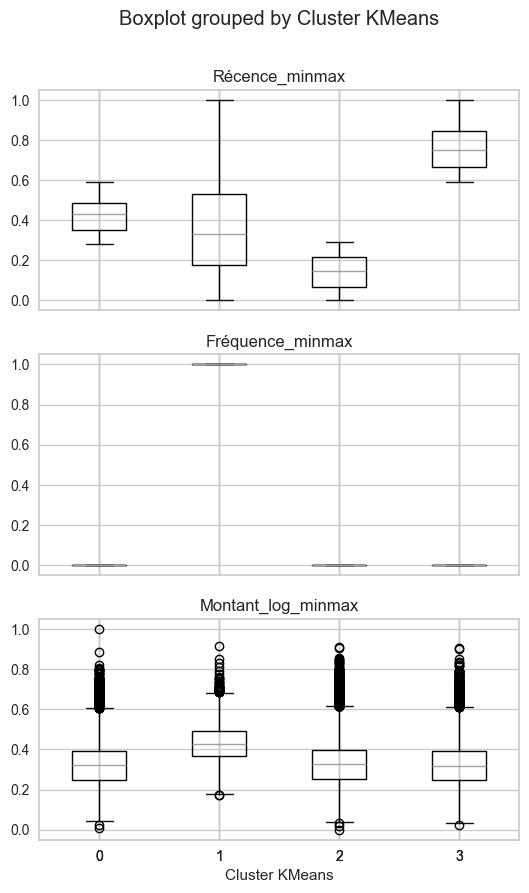

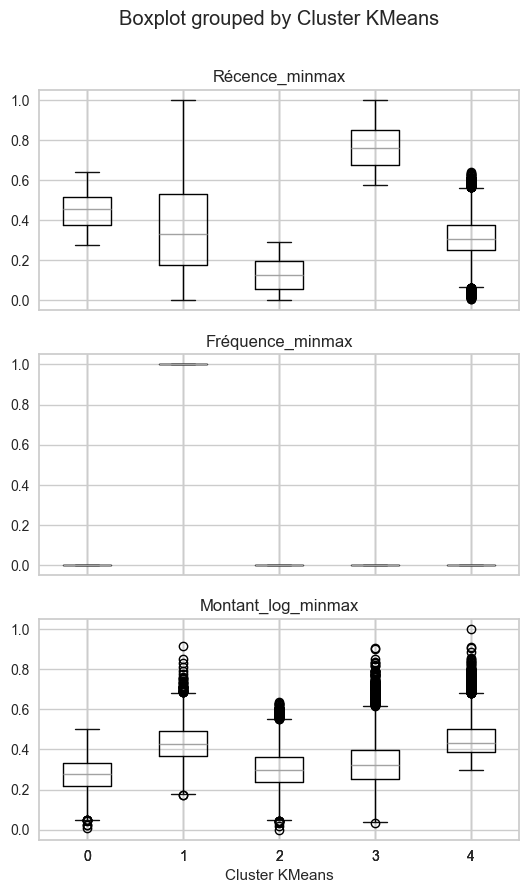

In [40]:
for k in (3, 4, 5):
    df_features['Cluster KMeans'] = fit_kmeans(X, k, random_state=0)
    boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_log_minmax'], by='Cluster KMeans', grid=True, figsize=(6, 10), layout=(3, 1))

* Le nombre de clusters semble ne pas avoir d'influence, les chevauchements persistent
* Ces tests confirment les mauvais résultats obtenus après transformation logarithmique de la varianle `Montant`

# 4 Troisième test KMeans - Feature `Montant` normalisée via QuantileTransformer

In [41]:
# Chargement du nouveau dataset
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_qt']]

## 4.1 Détermination du nombre optimal de clusters

### 4.1.1 Elbow Method

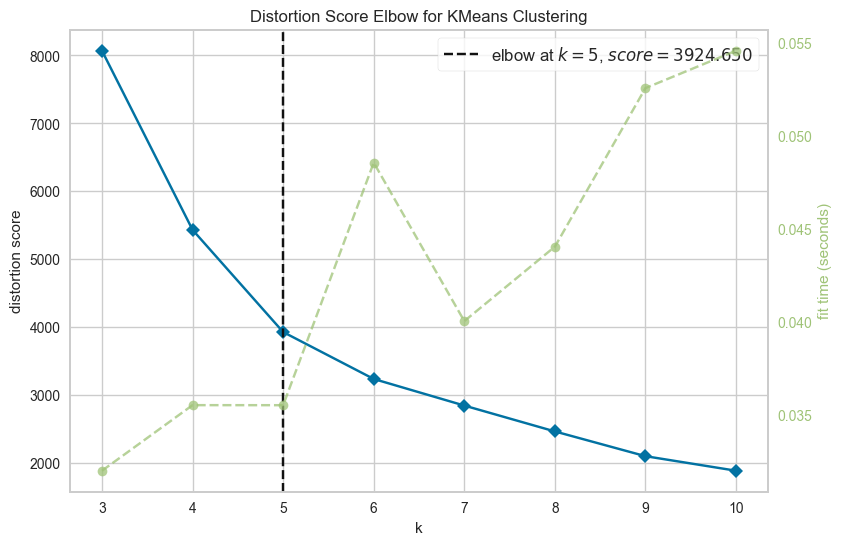

In [42]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

### 4.1.2 Scores de Silhouette

In [43]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
4,0.402894
3,0.392082
5,0.387885
6,0.373895
7,0.368088
9,0.364656
10,0.362387
8,0.349305


* La méthode des scores de Silhouette indique un nombre optimal de clusters de **4**

### 4.1.3 Calinski-Harabasz

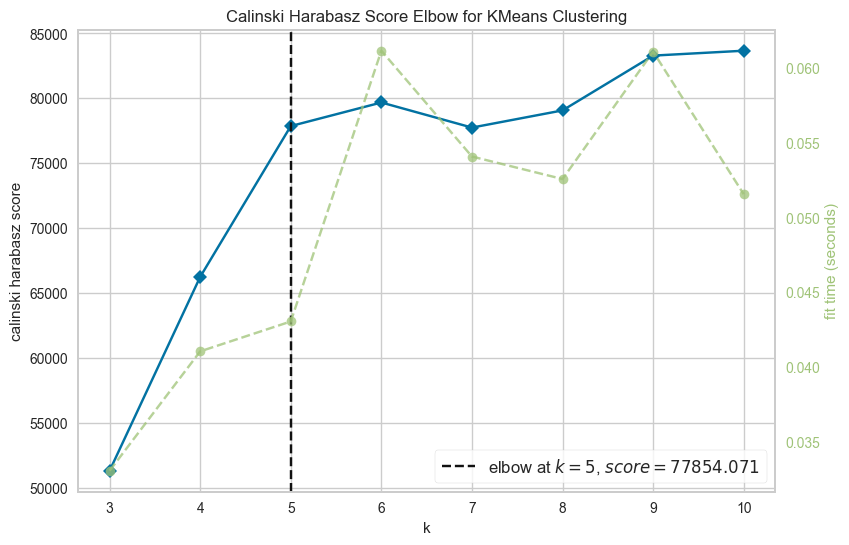

In [44]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* La méthode de Calinski Harabasz indique un nombre optimal de **5 clusters**  

* Les prochains tests se feront avec 4 et 5 clusters

## 4.2 Entrainement du modèle - 4 clusters

In [45]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
df_features['Cluster KMeans'] = fit_kmeans(X, 4, random_state=0)

### 4.2.1 Affichage des résultats

In [46]:
# Affichage du résultat
display(df_features)

,Client,Récence,Fréquence,Montant,Récence_minmax,Fréquence_minmax,Montant_minmax,Montant_log,Montant_qt,Montant_class,Montant_log_minmax,Montant_class_minmax,Satisfaction,Cluster KMeans
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,4.962145,0.636131,3,0.363304,0.375,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,3.338967,0.021178,1,0.136688,0.125,4.0,0
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4.468434,0.398488,2,0.294376,0.250,3.0,3
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3.798182,0.118413,1,0.200801,0.125,4.0,0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,5.287711,0.777711,4,0.408757,0.500,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,7.634540,0.993256,8,0.736404,1.000,5.0,1
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,4.449452,0.388941,2,0.291726,0.250,4.0,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4.731450,0.518331,3,0.331096,0.375,5.0,3
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,4.902976,0.605161,3,0.355043,0.375,5.0,1


### 4.2.2 Analyse des clusters

#### 4.2.2.1 Répartition des clients par cluster

,Cluster KMeans,Nombre de clients,%
0,0,33234,34.94
1,1,34586,36.36
2,2,2900,3.05
3,3,24401,25.65


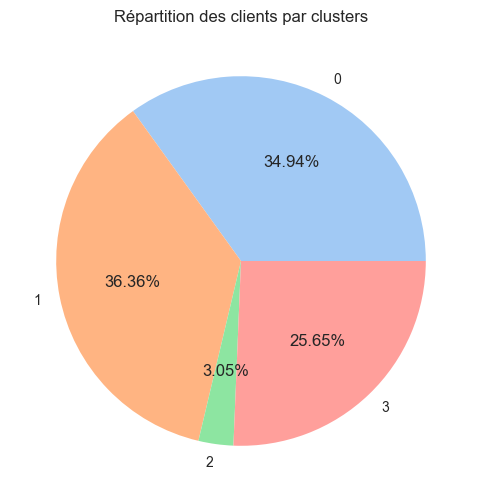

In [47]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster KMeans')

* La répartition est relativement homogène, avec 1 cluster moins peuplé  

#### 4.2.2.2 Distributions des features par cluster

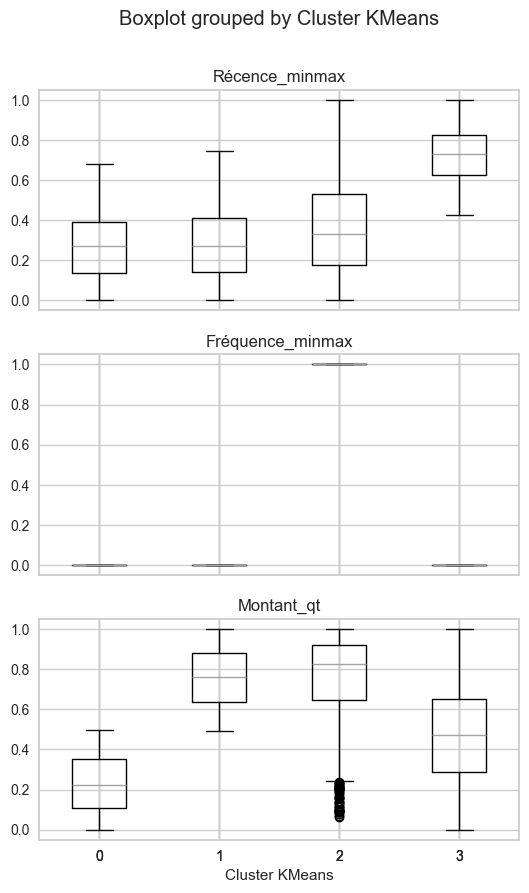

In [48]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_qt'], by='Cluster KMeans', grid=True, figsize=(6, 10), layout=(3, 1))

* Il y a un léger mieux au niveau de la feature `Montant` après normalisation par les quantiles, puisque les distributions pour clusters 0 et 1 ne se chevauchent pas
* Cette segmentation avec **4 clusters** n'est toutefois pas efficace 

## 4.3 Entrainement du modèle - 5 clusters

In [49]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
k = 5
df_features['Cluster KMeans'] = fit_kmeans(X, k, random_state=0)

### 4.3.1 Affichage des résultats

In [50]:
# Affichage du résultat
display(df_features)

,Client,Récence,Fréquence,Montant,Récence_minmax,Fréquence_minmax,Montant_minmax,Montant_log,Montant_qt,Montant_class,Montant_log_minmax,Montant_class_minmax,Satisfaction,Cluster KMeans
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,4.962145,0.636131,3,0.363304,0.375,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,3.338967,0.021178,1,0.136688,0.125,4.0,4
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4.468434,0.398488,2,0.294376,0.250,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3.798182,0.118413,1,0.200801,0.125,4.0,0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,5.287711,0.777711,4,0.408757,0.500,5.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,7.634540,0.993256,8,0.736404,1.000,5.0,3
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,4.449452,0.388941,2,0.291726,0.250,4.0,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4.731450,0.518331,3,0.331096,0.375,5.0,3
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,4.902976,0.605161,3,0.355043,0.375,5.0,1


### 4.3.2 Analyse des clusters

#### 4.3.2.1 Répartition des clients par cluster

,Cluster KMeans,Nombre de clients,%
0,0,20255,21.29
1,1,26711,28.08
2,2,2900,3.05
3,3,19073,20.05
4,4,26182,27.52


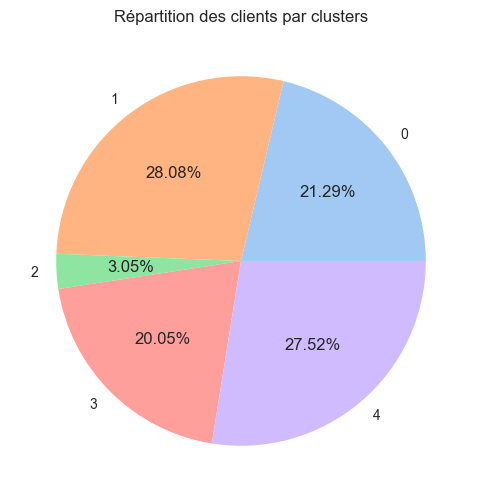

In [51]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster KMeans')

* La répartition est relativement homogène, avec 1 cluster moins peuplé  

#### 4.3.2.2 Distributions des features par cluster

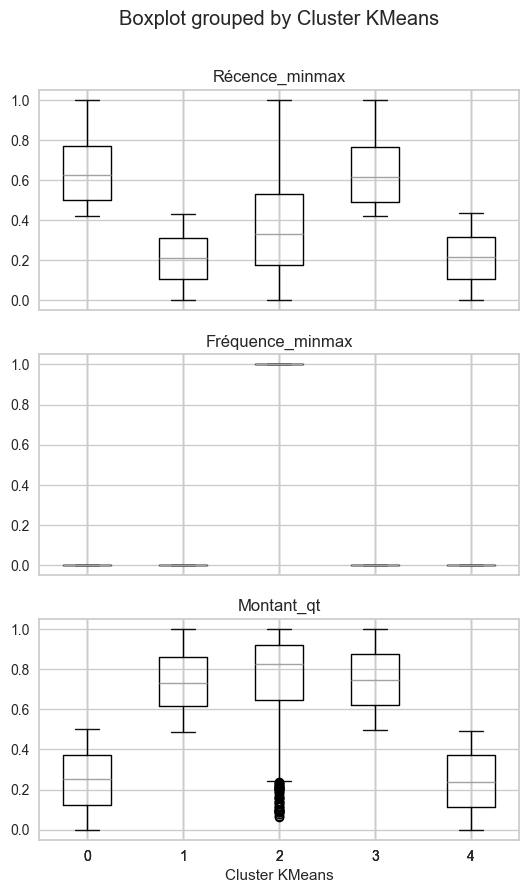

In [52]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_qt'], by='Cluster KMeans', grid=True, figsize=(6, 10), layout=(3, 1))

* Cette segmentation en 5 clusters, après normalisation par les quantiles de la variable `Montant`, donne un résultat satisfaisant et facilement interprétable :  
   * Cluster 0 : clients ayant commandé il y a longtemps (Récence élevée), n'ayant passée qu'une seule commande (Fréquence à 0), ayant peu dépensé (Montant faible)  
   * Cluster 1 : clients ayant commandé plus récemment, une seule commande, dépense plus importante  
   * Cluster 2 : clients ayant passé plusieurs commandes  
   * Cluster 3 : clients ayant commandé il y a longtemps, une seule commande, dépense élevée
   * Cluster 4 : clients ayant commandé plus récemment, une seule commande, dépense moins importante

### 4.3.3 Interprétations

* Tableau récapitulatif des caractéristisques statistiques de chaque cluster

In [53]:
# Calcul des récences en mois
df_features['Récence_mois'] = round(df_features['Récence'] / 30)

# Liste des features à analyser
features_to_analyze = ['Récence_mois', 'Fréquence', 'Montant']

# Création du dictionnaire d'agrégation
aggregations = {feature: ['min', 'max', 'mean', 'median'] for feature in features_to_analyze}
aggregations['Client'] = 'count'

# Aggrégation des données
cluster_summary_km5 = df_features.groupby('Cluster KMeans').agg(aggregations)

# Calcul du pourcentage
cluster_summary_km5['Percentage'] = (cluster_summary_km5['Client']['count'] / df_features['Client'].count()) * 100

# Affichage des statistiques
display(cluster_summary_km5)

Récence_mois                         Fréquence                  \
                        min   max       mean median       min max mean median   
Cluster KMeans                                                                  
0                       9.0  20.0  12.949445   13.0         0   0  0.0    0.0   
1                       0.0   9.0   4.301262    4.0         0   0  0.0    0.0   
2                       0.0  20.0   7.420000    7.0         1   1  1.0    1.0   
3                       8.0  20.0  12.866251   12.0         0   0  0.0    0.0   
4                       0.0   9.0   4.356123    4.0         0   0  0.0    0.0   

               Montant                               Client Percentage  
                   min       max        mean  median  count             
Cluster KMeans                                                          
0                10.07    107.90   63.774440   63.51  20255  21.293931  
1               105.29   7274.88  256.362708  175.80  26711  28.081076  
2                34.97   7571.63  310.503124  225.76   2900   3.048748  
3               107.24  13664.08  268.594605  181.64  19073  20.051303  
4                 9.59    105.65   62.003820   61.40  26182  27.524942

#### 4.3.3.1 Cluster 0 : les clients dormants

* Regroupe 21 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a plus de 9 mois  
* Ils ont dépensé moins de 110 réals, 64 réals en moyenne

#### 4.3.3.2 Cluster 1 : les nouveaux clients dépensiers

* Regroupe 28 % des clients
* Ils n'ont passé qu'une seule commande, il y a moins de 9 mois
* Ils ont dépensé plus de 105 réals, 50 % des clients de ce segment ont dépensé plus de 175 réals  

#### 4.3.3.3 Cluster 2 : les clients fidèles

* Regroupe 3 % des clients
* Ils ont passé plusieurs commandes, qui se répartissent sur toute la période
* Ils ont dépensé jusqu'à 7570 réals, avec une moyenne de 310 réals
* 50 % des clients de ce segment ont dépensé moins de 225 réals

#### 4.3.3.4 Cluster 3 : les clients occasionnels à fort potentiel

* Regroupe 20 % des clients
* Ils n'ont passé qu'une seule commande, qui date de 8 mois ou plus
* Ils ont dépensé plus de 105 réals, 50 % des clients de ce segment ont dépensé plus de 180 réals   

#### 4.3.3.5 Cluster 4 : les clients économes

* Regroupe 28 % des clients
* Ils n'ont passé qu'une seule commande, il y a moins de 9 mois
* Ils ont dépensé moins de 110 réals, 50 % des clients de ce segment ont dépensé plus de 61 réals  

# 5 Quatrième test KMeans - Feature `Montant` classée par tranches

* Malgré une segmentation intéressante en 5 clusters, il est intéressant de vérifier si le classement par tranches de montants peu aboutir à une répartition des clients différente

In [54]:
# Mise à jour de X
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']]

## 5.1 Détermination du nombre optimal de clusters

### 5.1.1 Elbow Method

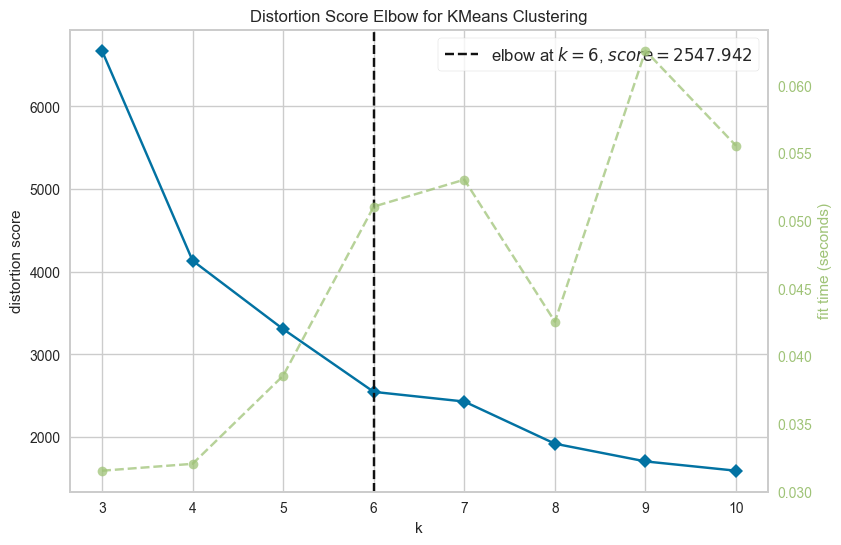

In [55]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

### 5.1.2 Scores de Silhouette

In [56]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
4,0.417270
3,0.395859
9,0.392795
8,0.392193
6,0.390219
7,0.382936
10,0.376752
5,0.370612


* La méthode des scores de Silhouette indique un nombre optimal de clusters de **4**

### 5.1.3 Calinski-Harabasz

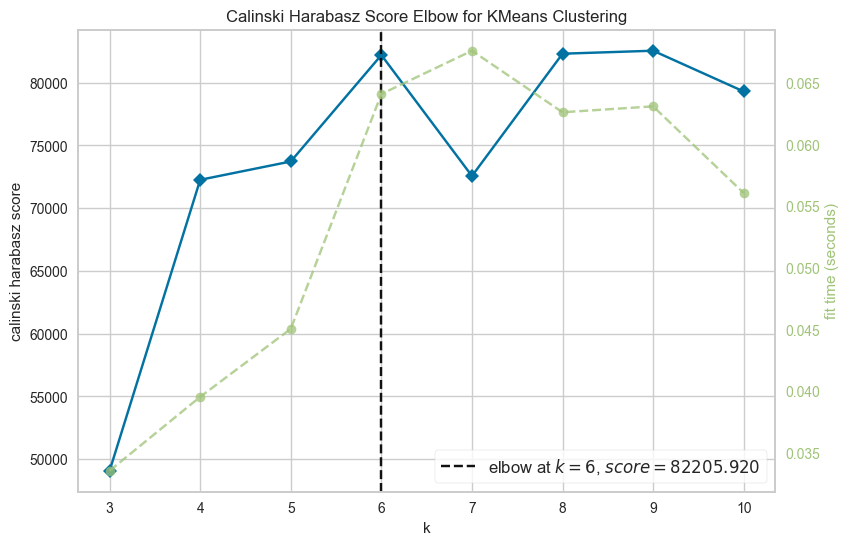

In [57]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* La méthode de Calinski Harabasz indique un nombre optimal de **6 clusters**  

## 5.2 KMeans 6 clusters

### 5.2.1 Distributions des features RFM par clusters

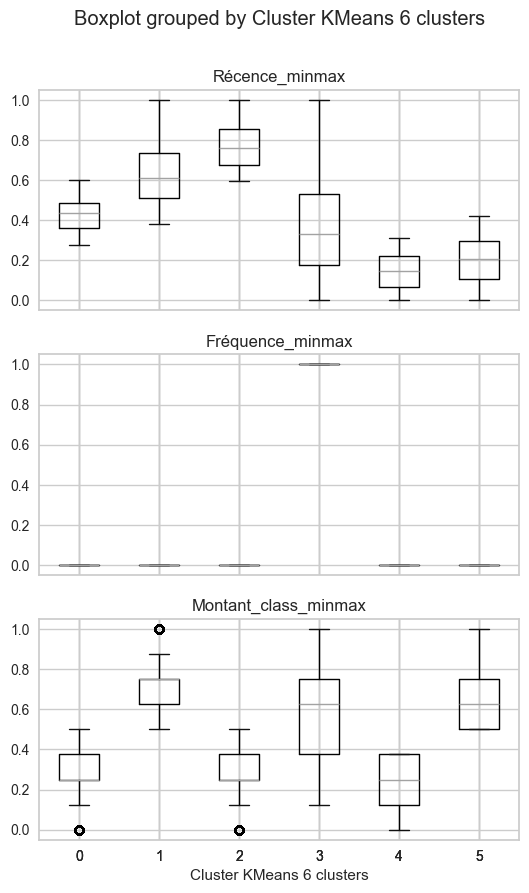

In [58]:
# Recherche des clusters
df_features['Cluster KMeans 6 clusters'] = fit_kmeans(X, 6, random_state=0)

# Affichage des distributions par clusters
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='Cluster KMeans 6 clusters', grid=True, figsize=(6, 10), layout=(3, 1))

* Même si certains boxplots montrent des distributions qui se chevauchent, la segmentation se fait très bien :
   * Le cluster 3 regroupe les clients ayant commandé plusieurs fois, ils se répartissent sur toute la plage temporelle et sur une large plage de montants
   * Les clusters 0, 2 et 4 regroupent les clients dont l'unique achat a été de plus faible montant :
       * Cluster 0 : récence moyenne  
       * Cluster 2 : récence plus élevée (commande plus ancienne)  
       * Cluster 4 : récence plus faible (commande plus récente)
    * Les cluster 1 et 5 regroupent les clients dont l'unique achat a été d'un montant plus important :  
       * Cluster 1 : commande plus ancienne  
       * Cluster 5 : commande plus récente  

### 5.2.3 Interprétations

* Tableau récapitulatif des caractéristisques statistiques de chaque cluster

In [59]:
# Liste des features à analyser
features_to_analyze = ['Récence_mois', 'Fréquence', 'Montant']

# Création du dictionnaire d'agrégation
aggregations = {feature: ['min', 'max', 'mean', 'median'] for feature in features_to_analyze}
aggregations['Client'] = 'count'

# Aggrégation des données
cluster_summary_km6 = df_features.groupby('Cluster KMeans 6 clusters').agg(aggregations)

# Calcul du pourcentage
cluster_summary_km6['Percentage'] = (cluster_summary_km6['Client']['count'] / df_features['Client'].count()) * 100

# Affichage des statistiques
display(cluster_summary_km6)

Récence_mois                         Fréquence      \
                                   min   max       mean median       min max   
Cluster KMeans 6 clusters                                                      
0                                  6.0  12.0   8.652712    9.0         0   0   
1                                  8.0  20.0  12.722572   12.0         0   0   
2                                 12.0  20.0  15.418742   15.0         0   0   
3                                  0.0  20.0   7.420000    7.0         1   1   
4                                  0.0   6.0   2.997244    3.0         0   0   
5                                  0.0   8.0   4.105457    4.0         0   0   

                                      Montant                                 \
                          mean median     min       max        mean   median   
Cluster KMeans 6 clusters                                                      
0                          0.0    0.0   10.07    199.95   86.878095   79.520   
1                          0.0    0.0  150.00  13664.08  382.927489  266.985   
2                          0.0    0.0   11.63    199.98   84.997761   77.570   
3                          1.0    1.0   34.97   7571.63  310.503124  225.760   
4                          0.0    0.0    9.59    149.89   78.452784   73.610   
5                          0.0    0.0  150.00   7274.88  328.459254  226.105   

                          Client Percentage  
                           count             
Cluster KMeans 6 clusters                    
0                          25440  26.744883  
1                          10482  11.019649  
2                          15783  16.592551  
3                           2900   3.048748  
4                          23950  25.178457  
5                          16566  17.415713

#### 5.2.3.1 Cluster 0 : les clients occasionnels

* Regroupe 27 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a plus de 6 mois et moins d'1 an  
* Ils ont dépensé moins de 200 réals, 50 % des clients de ce segment ont dépensé moins de 80 réals

#### 5.2.3.2 Cluster 1 : les clients à fort potentiel

* Regroupe 11 % des clients
* Ils n'ont passé qu'une seule commande, qui date de plus de 8 mois
* Ils ont dépensé plus de 150 réals, 50 % des clients de ce segment ont dépensé plus de 265 réals  

#### 5.2.3.3 Cluster 2 : les clients dormants

* Regroupe 17 % des clients
* Ils n'ont passé qu'une seule commande, qui date de plus d'1 an
* Ils ont dépensé moins de 200 réals, 50 % des clients de ce segment ont dépensé moins de 78 réals   

#### 5.2.3.4 Cluster 3 : les clients fidèles

* Regroupe 3 % des clients
* Ils ont passé plusieurs commandes, qui se répartissent sur toute la période
* Ils ont dépensé jusqu'à 7500 réals, avec une moyenne de 310 réals
* 50 % des clients de ce segment ont dépensé plus de 225 réals

#### 5.2.3.5 Cluster 4 : les nouveaux clients

* Regroupe 25 % des clients
* Ils n'ont passé qu'une seule commande, il y a moins de 6 mois
* Ils ont dépensé moins de 150 réals, 50 % des clients de ce segment ont dépensé moins de 75 réals  

#### 5.2.3.6 Cluster 5 : les clients prometteurs

* Regroupe 17 % des clients
* Ils n'ont passé qu'une seule commande, il y a moins de 8 mois
* Ils ont dépensé plus de 150 réals, 50 % des clients de ce segment ont dépensé plus de 225 réals  

### 5.2.4 Représentation graphique

* Pour représenter graphiquement les clusters, une PCA permet de réduire le dataset à 2 dimensions tout en expliquant un maximim de variance

In [60]:
# Initialisation de la PCA avec 2 composantes
pca = PCA(n_components=2, random_state=0)

In [61]:
# Récupération des 2 composantes
X_pca = pca.fit_transform(X)

In [62]:
# Pourcentage de variance expliquée par les 2 composantes principales
print(f"Les 2 principales composantes expliquent {round(pca.explained_variance_ratio_.sum() * 100, 2)} % de la variance.")

Les 2 principales composantes expliquent 80.6 % de la variance.


* Application de KMeans 6 clusters sur les composantes issues de la PCA

In [63]:
# Ajustement KMeans avec 6 clusters sur les données réduites PCA
kmeans_cluster = KMeans(n_clusters=6, random_state=0)
kmeans_cluster.fit(X_pca)

KMeans(n_clusters=6, random_state=0)

* Récupération des labels de clusters

In [64]:
labels = kmeans_cluster.labels_

* Récupération des centroïdes

In [65]:
centers = kmeans_cluster.cluster_centers_

* Affichage d'un scatterplot avec :  
   * les composantes principales PC1 et PC2 en abscisses et ordonnées
   * une colorisation par label de cluster
   * le centre de chaque cluster représenté par une croix noire

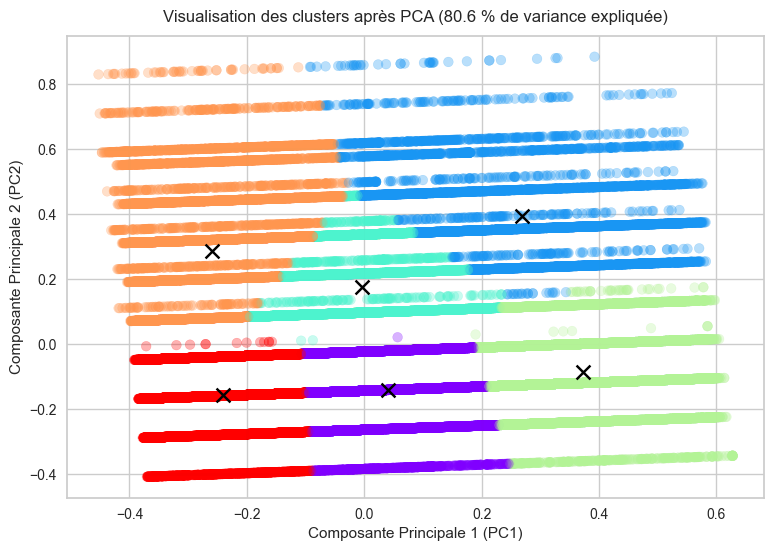

In [66]:
plt.figure()

# Tracé des points de données avec une couleur par cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.3)
# Tracé des centres des clusters
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100)

plt.title('Visualisation des clusters après PCA (80.6 % de variance expliquée)', pad=10)
plt.xlabel('Composante Principale 1 (PC1)')
plt.ylabel('Composante Principale 2 (PC2)')

plt.show()

# 6 Test DBSCAN

* DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering  
* Il forme des clusters en fonction de la densité des points dans un espace, il n'est pas basé sur la distance comme KMeans
* Il se distingue par sa capacité à trouver des clusters de formes arbitraires
* DBSCAN est capable de détecter et d'isoler les points de bruit (outliers), qui ne font partie d'aucun cluster

## 6.1 Feature `Montant` normalisée par quantiles

### 6.1.1 Préparation du dataset

* DBSCAN nécessite des features d'entrées normalisées, ce qui est le cas du dasaset présent
* DBSCAN peut monopiliser beaucoup de ressources, il est donc préférable de créer un **échantillon de données** pour les premiers tests, avant de les appliquer à l'ensemble du dataset  

#### 6.1.1.1 Sélection des features

In [67]:
# Sélection des features pour le clustering
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_qt']]

#### 6.1.1.2 Échantillonage

* Seulement 3% des clients ont commandé plus d'une fois, il ne faudrait pas que l'échantillonage passe à côté de ces 3%
* La méthode `StratifiedShuffleSplit` de scikit-learn permet de s'assurer que la proportion des classes est maintenue dans l'échantillon 

In [68]:
# Instanciation
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(X, X['Fréquence_minmax']):
    sample_set = X.loc[sample_index]

### 6.1.2 Recherche des hyperparamètres optimaux

**DBSCAN** repose sur 2 hyperparamètres :  
* **eps** (epsilon) : distance maximale entre deux points pour qu'ils soient considérés comme dans le même voisinage
* **min_samples** : nombre de points nécessaires pour former un cluster dense

#### 6.1.2.1 Epsilon

* Scikit-learn met à disposition la classe `NearestNeighbors` qui  calcule la distance au plus proche voisin de chaque point dans un échantillon de données
* En triant et en traçant ces distances, il est possible d'observer où la courbe commence à augmenter fortement
* Ce point est considéré comme le "coude" et peut donner une bonne estimation pour espilon  

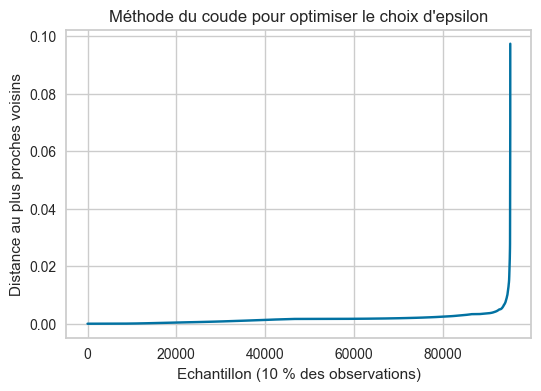

In [69]:
# Affichage de la courbe des distances et récupération de la distance maximale
epsilon_max = plot_elbow_nearest_neighbors(X)

In [70]:
# Distance maximale
print(f"Distance maximale entre 2 points : {epsilon_max}")

Distance maximale entre 2 points : 0.09741905590957284


* Chaque point ne se situant pas à une distance <= epsilon d'un autre point, sera considéré pas DBSCAN comme du bruit, et ne se verra pas attribuer de cluster
* Il n'est pas question qu'un grand nombre de clients n'appartiennent à aucun segment
* Le choix de l'hyperparamètre **eps** ne peut donc qu'être dans les plus hautes valeurs possibles, pour minimiser le bruit :
   * Avec un minimum de **0.02** on peut espérer un bruit minimum
   * Il sera par ailleurs inutile de tester **eps** au-delà de **0.098**

#### 6.1.2.2 Min_samples

* L'hyperparamètre **`min_samples`** détermine le nombre de point minimum pour former un cluster
* Pour une segmentation efficace de la clientèle il ne faut pas avoir de trop petits segments
* Cependant, dans le cas présent, il est intéressant de pouvoir distinguer les clients ayant passé plus d'une commande des autres
* Il y a exactement **2 900** clients n'ayant passé qu'une commande dans le dataset complet, soit environ **290** sur l'échantillon `sample_set` (10 % du dataset)  
* En fixant **`min_samples`** à **250**, cette contrainte devrait être respectée, même si `StratifiedShuffleSplit` n'avait pas respecté la proportion exacte de la feature `Fréquence`

#### 6.1.2.3 Tests des hyperparamètres

In [71]:
# Plages de paramètres 'eps'
eps_values = np.linspace(0.02, 0.098, 50)

# Valeur 'min_samples'
min_samples_value = 250

# Stockage des résultats
results = []

* Il n'existe pas de mécanisme comparable à `GridSearchCV` applicable à DBSCAN, mais cela peut être simuler en bouclant sur une plage de valeurs possibles pour **eps**
* Le Score de Silhouette sera utlisé pour mesurer la peformance de la segmentation

In [72]:
# Boucle sur les valeurs d'epsilon
for eps in eps_values:
    # Application du modèle DBSCAM sur l'échantillon
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_value).fit(sample_set[['Récence_minmax', 'Fréquence_minmax', 'Montant_qt']])
    # Récupération des labels de clusters
    labels = dbscan.labels_
    
    # Calcul du score de silhouette, sauf si tous les points sont considérés comme du bruit
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(sample_set[['Récence_minmax', 'Fréquence_minmax', 'Montant_qt']], labels)
    else:
        silhouette_avg = -1
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Stockage des résultats
    results.append((eps, min_samples_value, n_clusters_, n_noise_, silhouette_avg))

* Affichage des 10 meilleurs résultats des segmentations entre 3 et 10 clusters

In [73]:
# Conversion des résultats en dataframe
results_df = pd.DataFrame(results, columns=['eps', 'min_samples_value', 'n_clusters', 'n_noise', 'silhouette_score'])
results_df.sort_values(by='silhouette_score', ascending=False, inplace=True)

In [74]:
# Affichage des 10 meilleurs résultats
mask = (results_df['n_clusters'] >= 2) & (results_df['n_clusters'] <= 10)
display(results_df.loc[mask].head(10))

,eps,min_samples_value,n_clusters,n_noise,silhouette_score
36,0.077306,250,3,4251,-0.016293
34,0.074122,250,4,7156,-0.233308
35,0.075714,250,5,5571,-0.240232
33,0.072531,250,3,7823,-0.242691
32,0.070939,250,2,8722,-0.269140


* Avec un nombre de points de bruit bien trop important et des scores de silhouette négatifs, aucune segmentation ne peut être retenue

## 6.2 Feature `Montant` classée par tranches

### 6.2.1 Préparation du dataset

#### 6.2.1.1 Sélection des features

In [75]:
# Sélection des features pour le clustering
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']]

#### 6.2.1.2 Échantillonage

* L'échantillonage doit être refait puisque le dataset a changé

In [76]:
# Instanciation
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(X, X['Fréquence_minmax']):
    sample_set = X.loc[sample_index]

### 6.2.2 Recherche des hyperparamètres optimaux

#### 6.2.2.1 Epsilon

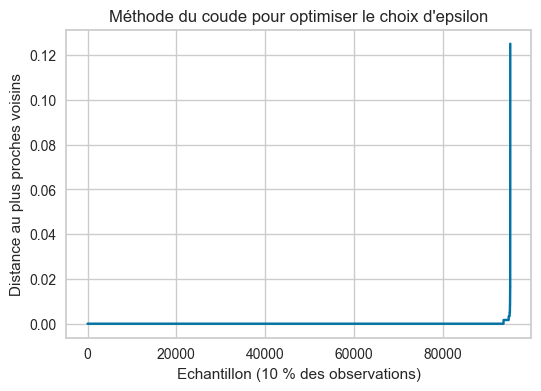

In [77]:
# Affichage de la courbe des distances et récupération de la distance maximale
epsilon_max = plot_elbow_nearest_neighbors(X)

In [78]:
# Distance maximale
print(f"Distance maximale entre 2 points : {epsilon_max}")

Distance maximale entre 2 points : 0.12501107367595612


* Avec un minimum de **0.10** on peut espérer un bruit minimum
* Il sera inutile de tester **eps** au-delà de **0.125**

#### 6.2.2.2 Min_samples

* Comme précédemment **`min_samples`** peut être fixé à **250**

#### 6.2.2.3 Tests des hyperparamètres

In [79]:
# Plages de paramètres 'eps'
eps_values = np.arange(0.1, 0.125, 0.0005)

# Valeur 'min_samples'
min_samples_value = 250

# Stockage des résultats
results = []

In [80]:
# Boucle sur les valeurs d'epsilon
for eps in eps_values:
    # Application du modèle DBSCAM sur l'échantillon
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_value).fit(sample_set[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']])
    # Récupération des labels de clusters
    labels = dbscan.labels_
    
    # Calcul du score de silhouette, sauf si tous les points sont considérés comme du bruit
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(sample_set[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']], labels)
    else:
        silhouette_avg = -1
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Stockage des résultats
    results.append((eps, min_samples_value, n_clusters_, n_noise_, silhouette_avg))

* Affichage des 10 meilleurs résultats des segmentations entre 3 et 10 clusters

In [81]:
# Conversion des résultats en dataframe
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette_score'])
results_df.sort_values(by='silhouette_score', ascending=False, inplace=True)

In [82]:
# Affichage des 10 meilleurs résultats
mask = (results_df['n_clusters'] >= 2) & (results_df['n_clusters'] <= 10)
display(results_df.loc[mask].head(10))

,eps,min_samples,n_clusters,n_noise,silhouette_score
46,0.1230,250,5,1962,0.040305
45,0.1225,250,5,1962,0.040305
44,0.1220,250,5,1962,0.040305
43,0.1215,250,5,1962,0.040305
41,0.1205,250,5,1971,0.039737
40,0.1200,250,5,1971,0.039737
42,0.1210,250,5,1971,0.039737
38,0.1190,250,5,1979,0.039012
39,0.1195,250,5,1979,0.039012
37,0.1185,250,5,1979,0.039012


* Le meilleur résultat est obtenu avec **eps = 0.123** :
   * DBSCAN segmente le dataset en **5 clusters**
   * **1 962** points sont considérés comme du bruit, soit **2.05 %** des clients
   * Le score de Silhouette est très faible (**0.04**), indiquant une très faible perfomance du clustering : les clusters peuvent présenter des chevauchements significatifs
* Les résultats obtenus sont relativement stables sur la plage d'epsilon testée

## 6.3 Résultats DBSCAN

* Malgré un Score de Silhouette faible et un nombre de point de bruit important, il est intéressant d'appliquer ces hyperparamètres à un clustering DBSCAN sur les données d'Olist pour vérifier la manière dont sont constitués les clusters

### 6.3.1 Sur l'échantillon

* Application du modèle

In [83]:
# Lancement DBSCAN
n_clusters, n_noise, labels = fit_dbscan(sample_set, epsilon=0.123, min_samples=250)

In [84]:
# Ajout des labels de cluster au dataframe original
sample_set['Cluster DBSCAN'] = labels

In [85]:
# Affichages nombre de clusters et de points de bruit
print(f'Nombre estimé de clusters: {n_clusters}')
print(f'Nombre estimé de points de bruit: {n_noise}')

Nombre estimé de clusters: 5
Nombre estimé de points de bruit: 1962


* Répartition des features RFM par clusters

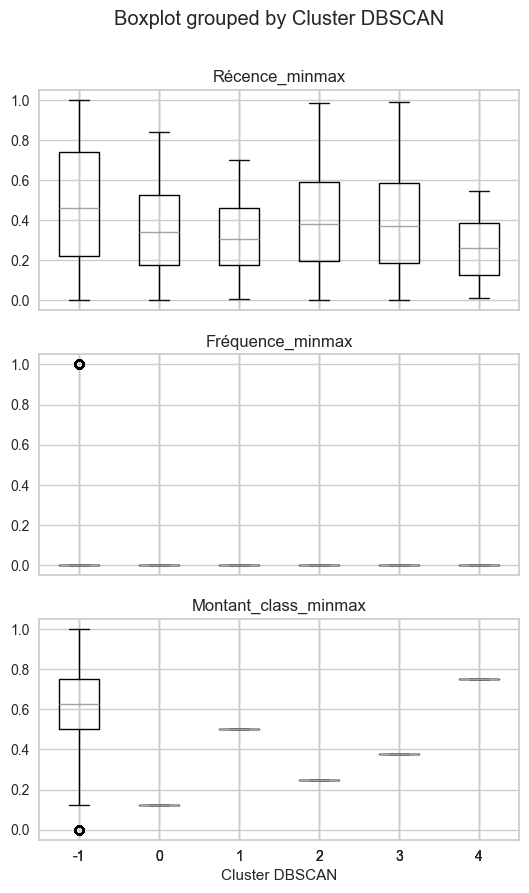

In [86]:
boxplots = sample_set.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='Cluster DBSCAN', grid=True, figsize=(6, 10), layout=(3, 1))

* Sans surprise au regard des Score de Silhouette, le clustering DBSCAN ne fonctionne pas sur le dataset
* Le cluster labelisé **-1** correspond aux point de bruits
* L'agorithme n'a pas pu isoler les clients ayant passé plusieurs commandes (`Fréquence` à 1)
* Les chevauchements sur la variable `Récence` sont très importants
* Le clustering semble se faire uniquement sur des montants identiques ou très proches, qui ne couvre pas du tout la plage des possibilités

### 6.3.2 Sur le dataset complet

* Puisque l'échantillon était composé de 10 % du dataset, le paramètre `min_samples` doit être ajusté à **2500**

In [87]:
# Lancement DBSCAN
n_clusters, n_noise, labels = fit_dbscan(df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']], epsilon=0.123, min_samples=2500)

In [88]:
# Ajout des labels de cluster au dataframe original
df_features['Cluster DBSCAN'] = labels

In [89]:
# Affichages nombre de clusters et de points de bruit
print(f'Nombre estimé de clusters: {n_clusters}')
print(f'Nombre estimé de points de bruit: {n_noise}')

Nombre estimé de clusters: 5
Nombre estimé de points de bruit: 18748


* Répartition des features RFM par clusters

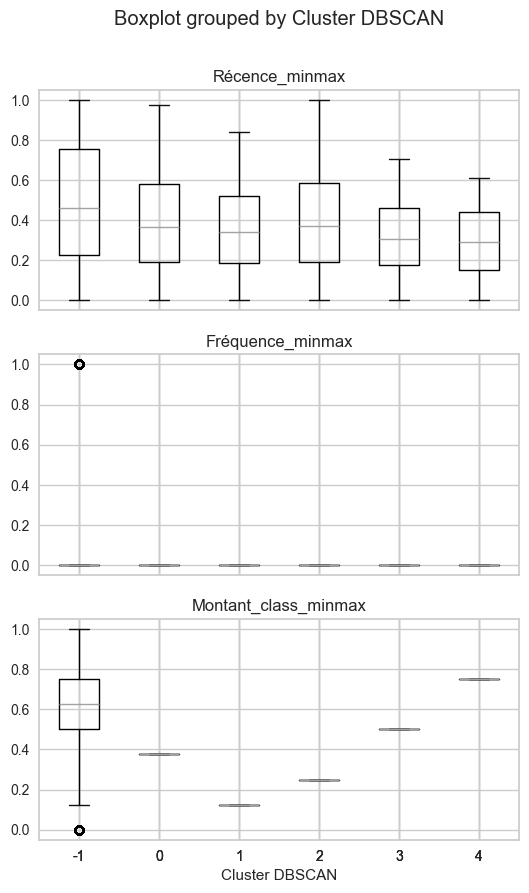

In [90]:
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='Cluster DBSCAN', grid=True, figsize=(6, 10), layout=(3, 1))

* Les résultats sont identiques, hormis le nombre de points de bruits qui passe de **1 962** sur l'échantillon à **18 748** sur le dataset complet, soit environ 10 fois plus, ce qui est logique car l'échantillon représentait 10 % du dataset

* Répartition des clients dans les clusters (à titre informatif)

,Cluster DBSCAN,Nombre de clients,%
0,-1,18748,19.71
1,0,18371,19.31
2,1,13266,13.95
3,2,28050,29.49
4,3,9897,10.40
5,4,6789,7.14


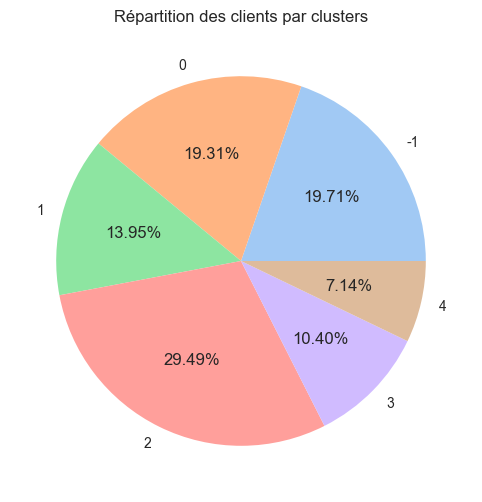

In [91]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster DBSCAN')

* Le cluster labellisé **-1** est celui des points de bruit, c'est-à-dire celui des clients qui n'ont pas pu être classés  
* Près de **20 %** des clients n'appartiennent à aucun segment !

### 6.3.3 Conclusion du test DBSCAN

* L'alogrithme DBSCAN repose sur la notion de densité, avec 2 paramètres :
   * **eps** : distance maximale entre 2 points pour être considérés comme voisins
   * **min_samples** : nombre de minimal points pour former un cluster
* Une des particularité de DBSCAN est d'être capable de considérer certains points comme du bruit

* La répartition de la feature `Fréquence` (**97 %** vs **3 %**) rend difficle à l'algorithme de ne pas considérer les clients ayant passé plusieurs commandes comme des points de bruit.

# 7 Test AgglomerativeClustering

* **AglomerativeClustering** est un algorithme de clustering hiérarchique  
* Il forme des clusters en considérant au départ que chaque point est un cluster, puis les fusionne progressivement en groupes plus grands
* La fusion de 2 clusters se fait en fonction :
   * de la méthode de calcul de la distance choisie : euclidienne, Manhattan... (hyperparamètre **metric**)   
   * de la méthode de 'linkage' choisie (hyperparamètre **linkage**) :  
      * liaison complète (complete) : la distance entre 2 clusters est la distance entre leurs 2 points les plus éloignés  
      * liaison simple (single) : la distance entre 2 clusters est la distance entre leurs 2 points les plus proches  
      * liaison moyenne (average) : la distance entre 2 clusters est la moyenne de toutes les distances entre les points d'un cluster et les points de l'autre  
      * liaison de Ward (ward) : à chaque fois que 2 clusters sont regroupés en 1, cherche à minimiser l'augmentation d'inertie intraclasse due au regroupement des 2 clusters.   
* Les fusions de clusters et les distances à chaque étape de fusion peuvent être visualisées à l'aide d'un **dendrogramme**

* Puisque les résultats avec KMeans ont été concluant avec les versions de la feature `Montant` normalisée par les quantiles et celle classée par tranches de montants, l'alogorithme **AgglomerativeClustering** sera testé avec ces 2 variantes.

## 7.1 Choix des hypermaramètres

* Plutôt que d'essayer d'obtenir des clusters éloignés les uns des autres, il est préférable d'obtenir des clusters dont les points de données sont les plus proches les uns des autres
* La méthode de liaison permettant cela est la méthode **ward**
* Lorsque `linkage='ward'`, la seule méthode de calcul de distance possible est la **distance euclidienne** (`metric='euclidean'`)

## 7.2 Feature `Montant` normalisée par les quantiles

### 7.2.1 Préparation du dataset

* Sélection des features

In [92]:
# Sélection des features
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_qt']]

* Échantillonage

In [93]:
# Instanciation
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(X, X['Fréquence_minmax']):
    sample_set = X.loc[sample_index]

### 7.2.2 Réalisation du clustering

In [94]:
# Initialisation avec :
#    * Linkage de type 'ward'
#    * n_cluster=None : Pas de nombre de clusters prédéterminé
#    * distance_threshold=0 : Seuil de distance de liaison au-delà duquel les clusters ne seront pas fusionnés à 0
#                             pour laisser à l'algorithme la possibilité de fusionner 2 clusters même s'ils sont proches
agglomerative = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

# Fit du modèle
agglomerative = agglomerative.fit(sample_set)

### 7.2.3 Dendrogramme

* La bibliothèque SciPy fournit la méthode `dendrogram` qui comme son nom l'indique, affiche un dendrogramme  
* L'attribut `.children_` d'un modèle sk-learn `AgglomerativeClustering` est un tableau contenant les regroupements de clusters successifs, chaque ligne contenant les indices des deux clusters
* A partir de ce tableau, la méthode `linkage` peut calculer une matrice de liaison Z contentant les distances entre les clusters.
* Cette matrice de liason doit être fournie à la méthode `dendrogram`

In [95]:
# Création de la matrice de liaison Z (distances inter_clusters)
Z = sch.linkage(agglomerative.children_, method='ward')

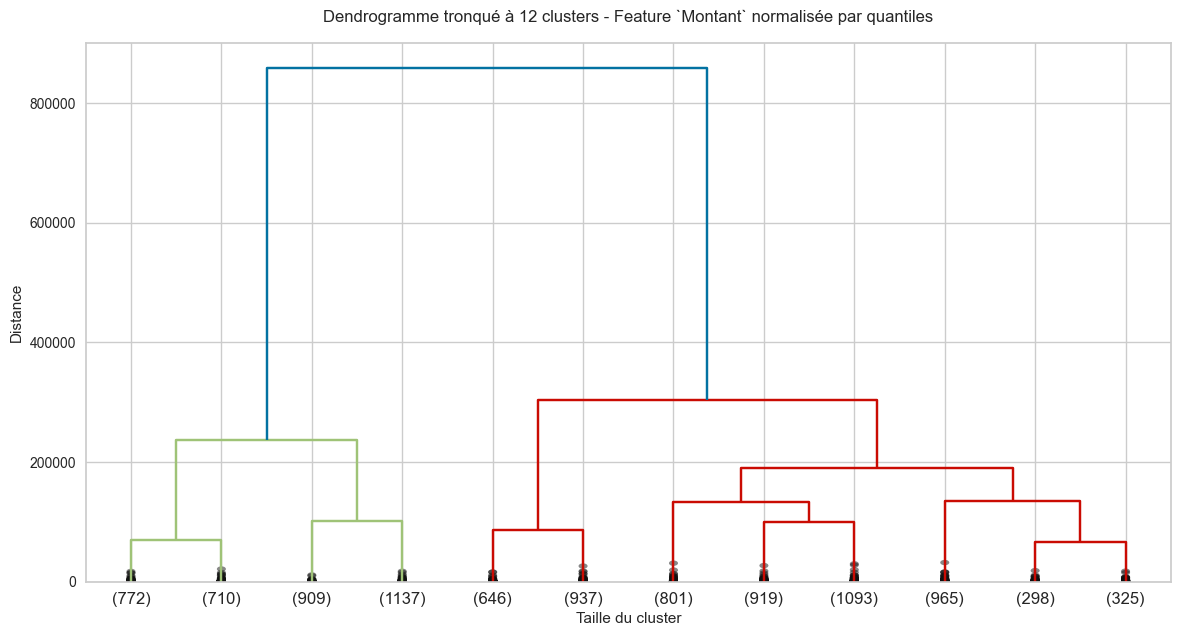

In [96]:
# Affichage du dendrogramme
plt.figure(figsize=(14, 7))
dendro = sch.dendrogram(Z, truncate_mode='lastp', p=12, show_contracted=True)
plt.title(f'Dendrogramme tronqué à 12 clusters - Feature `Montant` normalisée par quantiles', pad=15)
plt.xlabel('Taille du cluster')
plt.ylabel('Distance')
plt.show()

* Le dendrogramme suggère un nombre optimal de clusters de **2**, puisque la plus grande distance entre 2 clusters se trouve entre les segmentations en 2 et 3 clusters  
* Ce clustering n'est pas exploitable au niveau métier  

## 7.3 Feature `Montant` classée par tranches

### 7.3.1 Préparation du dataset

* Sélection des features

In [97]:
# Sélection des features
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']]

* Échantillonage

In [98]:
# Instanciation
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(X, X['Fréquence_minmax']):
    sample_set = X.loc[sample_index]

### 7.2.2 Réalisation du clustering

In [99]:
# Initialisation avec :
#    * Linkage de type 'ward'
#    * n_cluster=None : Pas de nombre de clusters prédéterminé
#    * distance_threshold=0 : Seuil de distance de liaison au-delà duquel les clusters ne seront pas fusionnés à 0
#                             pour laisser à l'algorithme la possibilité de fusionner 2 clusters même s'ils sont proches
agglomerative = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

# Fit du modèle
agglomerative = agglomerative.fit(sample_set)

### 7.2.3 Dendrogramme

* La bibliothèque SciPy fournit la méthode `dendrogram` qui comme son nom l'indique, affiche un dendrogramme  
* L'attribut `.children_` d'un modèle sk-learn `AgglomerativeClustering` est un tableau contenant les regroupements de clusters successifs, chaque ligne contenant les indices des deux clusters
* A partir de ce tableau, la méthode `linkage` peut calculer une matrice de liaison Z contentant les distances entre les clusters.
* Cette matrice de liason doit être fournie à la méthode `dendrogram`

In [100]:
# Création de la matrice de liaison Z (distances inter_clusters)
Z = sch.linkage(agglomerative.children_, method='ward')

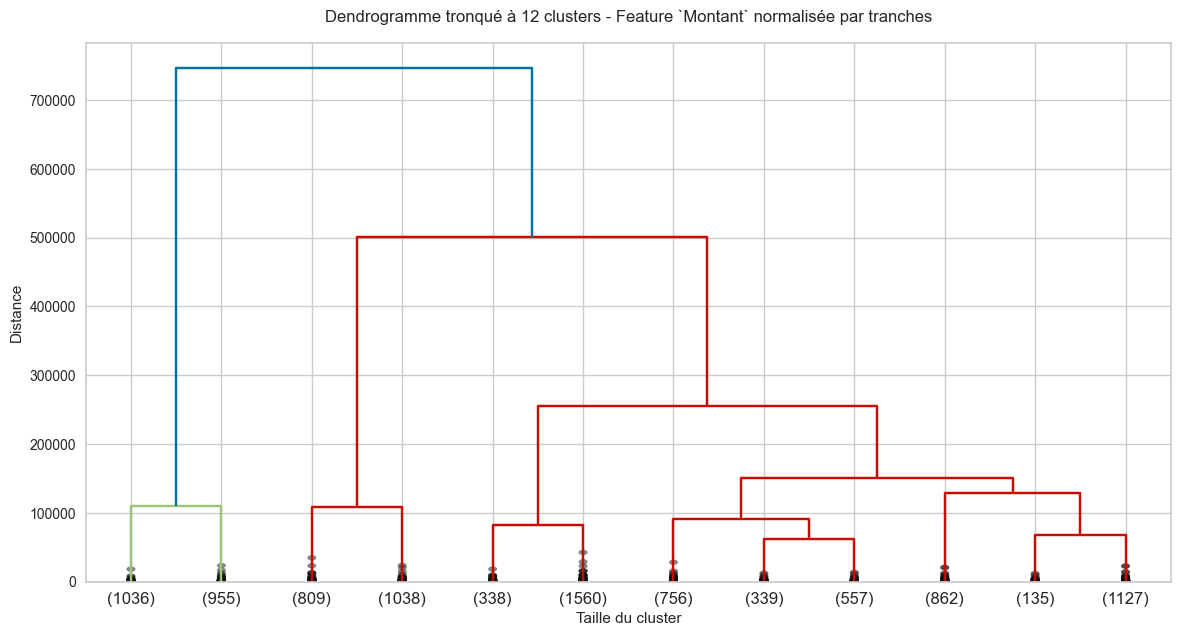

In [101]:
# Affichage du dendrogramme
plt.figure(figsize=(14, 7))
dendro = sch.dendrogram(Z, truncate_mode='lastp', p=12, show_contracted=True)
plt.title(f'Dendrogramme tronqué à 12 clusters - Feature `Montant` normalisée par tranches', pad=15)
plt.xlabel('Taille du cluster')
plt.ylabel('Distance')
plt.show()

* Le choix entre une segmentation en 2 ou 3 clusters n'est pas visuellement pas nette, les distances semblent identiques
* Segmenter les clients en 2 clusters n'aurait pas de sens au niveau métier, regardons ce qu'une segmentation en **3 clusters** donnerait

### 7.2.4 Segmentation en 3 clusters

#### 7.2.4.1 Clustering

In [102]:
# Initialisation AgglomerativeClustering avec 3 clusters, linkage ward
agg_clust = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

* Fit sur le jeu de données complet et récupération des labels

In [103]:
# Fit sur le jeu de données complet
agg_clust.fit(X)

AgglomerativeClustering(n_clusters=3)

In [104]:
# Ajout des labels de clusters à df_features
df_features['Cluster AggClust'] = agg_clust.labels_

* Calcul du score de silhouette

In [105]:
# Calcul du score de silhouette
silhouette_avg = silhouette_score(X, agg_clust.labels_)

print('Silhouette Score:', silhouette_avg)

Silhouette Score: 0.37151480823454286


#### 7.2.4.2 Répartition des clients par cluster

,Cluster AggClust,Nombre de clients,%
0,0,21715,22.83
1,1,33109,34.81
2,2,40297,42.36


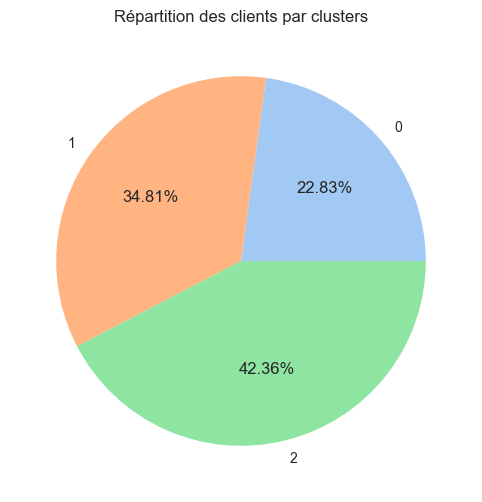

In [106]:
# Répartition des clients par cluster
display_customer_distribution_by_cluster(df_features, 'Client', 'Cluster AggClust')

#### 7.2.4.3 Distribution des features RFM par cluster

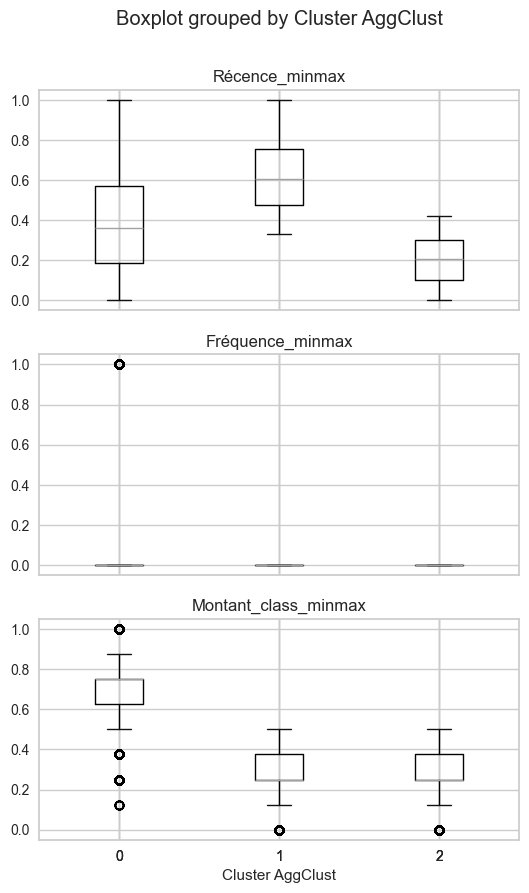

In [107]:
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='Cluster AggClust', grid=True, figsize=(6, 10), layout=(3, 1))

* Interprétation :
   * Le cluster 0 rassemble des clients sur quasiment l'intégralité des valeurs des 3 features RFM. C'est le seul cluster contenant les clients ayant passé plus d'une commande
   * Clusters 1 et 2 :
      * Clients n'ayant passé qu'une commande, avec un montant dans la fourchette basse
      * Le cluster 1 correspond aux commandes passées il y a relativement longtemps, le cluster 2 aux commendes passées plus récemment
      * Il y a cependant chevauchement au niveau de la Récence, ce qui signifie que 2 clients ayant passés une seule commande à la même date, d'un même montant, pourraient se trouver dans 2 clusters différents
* Cette segmentation n'est pas efficace car il y a des cas de chevauchements : certains clients ayant des caractéristiques similaires pourraient se trouver dans des clusters différents

## 7.3 Conclusion du test AgglomerativeClustering

* La recherche d'une segmentation entre 3 et 10 clusters via le modèle **AgglomerativeClustering** n'a pas donné de résultat satisfaisant
* A COMPLETER